# Learning what Michael (from The Office) speaks
There script form The Office is available [here](http://officequotes.net/no2-10.php). Taking dialogues from S02E10, I want see what word2vec learns from it

### Importing libraries

In [48]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import collections
import tensorflow as tf

### Loading data

In [49]:
# Loading data
data = pd.read_csv('data/office_s02e10.csv', names=['Character','Dialogue'])

In [50]:
# Looking at what we are working with
data.Character.value_counts()
# So we have 94 dialogues from Michael that we can word with

Michael                              94
Dwight                               51
Jim                                  27
Pam                                  22
Oscar                                20
Ryan                                 18
Kevin                                14
Kelly                                13
Darryl                               11
Angela                               10
Meredith                             10
Creed                                 9
Phyllis                               8
Roy                                   8
Toby                                  7
Stanley                               5
Todd Packer                           3
Liquor Store Clerk                    2
Bob Vance                             2
JIm                                   1
All                                   1
Kevin & Oscar                         1
Phyllis, Meredith, Michael, Kevin     1
Name: Character, dtype: int64

### Manipulating data
Here, we do several thing to ensure the text can be processed:
1. Extract only diaolgues from Michael
2. Convert to lower case
3. Remove symbols

In [51]:
# Let us extract only Michael's words
michael_says = data[data['Character'] == 'Michael']

In [52]:
#pre processing the text 

def normalize_text(text):

    text=text.lower()
    text = re.sub('@[^\s]+','', text)
    text = re.sub('#([^\s]+)', '', text)
    text = re.sub('[:;>?<=*+()&,\-#!$%\{˜|\}\[^_\\@\]1234567890’‘]',' ', text)
    text = re.sub('[\d]','', text)
    text = text.replace(".", '')
    text = text.replace("'", '')
    text = text.replace("`", '')
    text = text.replace("'s", '')
    text = text.replace("/", ' ')
    text = text.replace("\"", ' ')
    text = text.replace("\\", '')
    re.sub(' +', ' ', text)
    text=text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    #normalize some utf8 encoding
    text = text.replace("\x9d",'').replace("\x8c",'')
    text = text.replace("\xc2",'')
    text = text.replace("\xa0",'')
    text = text.replace("\x9d\x92", '').replace("\x9a\xaa\xf0\x9f\x94\xb5", '').replace("\xf0\x9f\x91\x8d\x87\xba\xf0\x9f\x87\xb8", '').replace("\x9f",'').replace("\x91\x8d",'')
    text = text.replace("\xf0\x9f\x87\xba\xf0\x9f\x87\xb8",'').replace("\xf0",'').replace('\xf0x9f','').replace("\x9f\x91\x8d",'').replace("\x87\xba\x87\xb8",'')
    text = text.replace("\xe2\x80\x94",'').replace("\x9d\xa4",'').replace("\x96\x91",'').replace("\xe1\x91\xac\xc9\x8c\xce\x90\xc8\xbb\xef\xbb\x89\xd4\xbc\xef\xbb\x89\xc5\xa0\xc5\xa0\xc2\xb8",'')
    text = text.replace("\xe2\x80\x99s", "").replace("\xe2\x80\x98", '').replace("\xe2\x80\x99", '').replace("\xe2\x80\x9c", "").replace("\xe2\x80\x9d", "")
    text = text.replace("\xe2\x82\xac", "").replace("\xc2\xa3", "").replace("\xc2\xa0", "").replace("\xc2\xab", "").replace("\xf0\x9f\x94\xb4", "").replace("\xf0\x9f\x87\xba\xf0\x9f\x87\xb8\xf0\x9f", "")
    text =  re.sub(r"\b[a-z]\b", "", text)
    text=re.sub( '\s+', ' ', text).strip()
    
    text=re.sub(r'\.+', ".", text)
    text=re.sub(r'\.\.+', ' ', text).replace('.', '')
    # Replace multiple dots with space
    text = re.sub('\.\.+', ' ', text) 
    # Remove single dots
    text = re.sub('\.', '', text)
    text = re.sub(r'\.{2,}', ' ', text)
    text = re.sub(r'\.{1}', '', text)
    
    return text

In [53]:
sentences = michael_says["Dialogue"].tolist()
normalized_sentences = []
for sentence in sentences:
    norm_sent=normalize_text(sentence)
    normalized_sentences.append(norm_sent)

### Making a word dictionary

In [54]:
# sentences to words and count
words=" ".join(normalized_sentences).split() 
count= collections.Counter(words).most_common() 
print ("Word count of top 5 words", count[:5])

('Word count of top 5 words', [('the', 44), ('you', 40), ('it', 39), ('to', 34), ('and', 28)])


In [55]:
# Building dictionaries
unique_words =  [i[0] for i in count]
dic = {w: i for i, w in enumerate(unique_words)} #dic, word -> id cats:0 dogs:1 ......
voc_size = len(dic)
print "Size of current vocabulary = %d" %(voc_size)

Size of current vocabulary = 474


In [56]:
# Make list with the indices of every word
data = [dic[word] for word in words] 
print('Sample data', data[:10], words[:10])


('Sample data', [47, 16, 27, 13, 162, 6, 6, 76, 2, 421], ['here', 'we', 'are', 'oh', 'god', 'no', 'no', 'turn', 'it', 'around'])


### Making a CBOW model (context size = 1 around)

In [57]:
cbow_pairs = []
for i in range(1, len(data)-1) :
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]]);
    
print('Context pairs rank ids', cbow_pairs[:5])
print()

cbow_pairs_words = []
for i in range(1, len(words)-1) :
    cbow_pairs_words.append([[words[i-1], words[i+1]], words[i]])
print('Context pairs words', cbow_pairs_words[:5])

('Context pairs rank ids', [[[47, 27], 16], [[16, 13], 27], [[27, 162], 13], [[13, 6], 162], [[162, 6], 6]])
()
('Context pairs words', [[['here', 'are'], 'we'], [['we', 'oh'], 'are'], [['are', 'god'], 'oh'], [['oh', 'no'], 'god'], [['god', 'no'], 'no']])


### Making skip-gram pairs

In [58]:
skip_gram_pairs=[]

for c in cbow_pairs:
    skip_gram_pairs.append([c[1],c[0][0]])
    skip_gram_pairs.append([c[1],c[0][1]])
print('skip-gram pairs', skip_gram_pairs[:5])
print()
skip_gram_pairs_words=[]
for c in cbow_pairs_words:
    skip_gram_pairs_words.append([c[1],c[0][0]])
    skip_gram_pairs_words.append([c[1],c[0][1]])
print('skip-gram pairs words', skip_gram_pairs_words[:5])

('skip-gram pairs', [[16, 47], [16, 27], [27, 16], [27, 13], [13, 27]])
()
('skip-gram pairs words', [['we', 'here'], ['we', 'are'], ['are', 'we'], ['are', 'oh'], ['oh', 'are']])


### Training model

In [59]:
def get_batch(size):
    assert size<len(skip_gram_pairs)
    X=[]
    Y=[]
    rdm = np.random.choice(range(len(skip_gram_pairs)),size,replace=False)
    
    for r in rdm:
        X.append(skip_gram_pairs[r][0])
        Y.append([skip_gram_pairs[r][1]])
    return X , Y

# generate_batch test
print ('Batches (x, y)', get_batch(3))

('Batches (x, y)', ([118, 3, 198], [[63], [4], [243]]))


In [60]:
batch_size = 20
embedding_size = 2
num_sampled = 15    # Number of negative examples to sample.

X= tf.placeholder(tf.int32,shape=[batch_size]) #inputs
Y= tf.placeholder(tf.int32,shape=[batch_size,1]) #labels

with tf.device("/cpu:0"):
      # Look up embeddings for inputs.
    embeddings = tf.Variable(tf.random_uniform([voc_size,embedding_size],-1.0,1.0))
    embed = tf.nn.embedding_lookup(embeddings, X) # lookup table
    
# Construct the variables for the NCE loss
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# Compute the average NCE loss for the batch.
# This does the magic:
#   tf.nn.nce_loss(weights, biases, inputs, labels, num_sampled, num_classes ...)
# It automatically draws negative samples when we evaluate the loss.
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, Y, embed, num_sampled, voc_size))
# Use the adam optimizer
optimizer = tf.train.AdamOptimizer(1e-1).minimize(loss)

In [61]:
epochs=10000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        
        batch_inputs, batch_labels = get_batch(batch_size)
        _,loss_val=sess.run([optimizer,loss],feed_dict = {X : batch_inputs, Y : batch_labels })
        
        if epoch % 1000 == 0:
            print("Loss at ", epoch, loss_val) # Report the loss
    
    # Final embeddings are ready for you to use. Need to normalize for practical use
    trained_embeddings = embeddings.eval()
    




('Loss at ', 0, 39.945152)
('Loss at ', 1000, 4.7807636)
('Loss at ', 2000, 3.1857991)
('Loss at ', 3000, 4.1901145)
('Loss at ', 4000, 3.4615211)
('Loss at ', 5000, 3.8165126)
('Loss at ', 6000, 4.10783)
('Loss at ', 7000, 3.6879299)
('Loss at ', 8000, 3.9120915)
('Loss at ', 9000, 3.384709)


### Visualizing embeddings

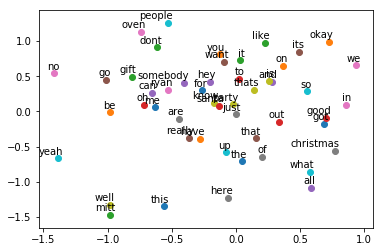

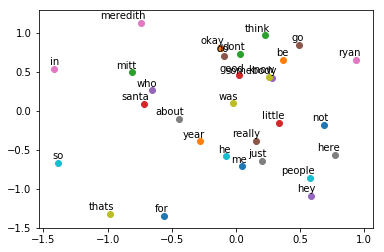

In [62]:

if trained_embeddings.shape[1] == 2:
    labels = unique_words[:50] # Show top 10 words
    for i, label in enumerate(labels):
        x, y = trained_embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
            textcoords='offset points', ha='right', va='bottom')
    plt.show()
    

if trained_embeddings.shape[1] == 2:
    labels = unique_words[30:60] # Show top 10 words
    for i, label in enumerate(labels):
        x, y = trained_embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
            textcoords='offset points', ha='right', va='bottom')

    plt.show()

See more about TSNE here: https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac